In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
## Inputs to the model
lr = 0.0002
b1 = 0.5
b2 = 0.999    
epoch = 10

data_dir = r'/home/ihg6kor/GenAI_model_implementation/dataset'





# Cycle GAN
![Cycle-GAN](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

## Step 1. Define Generator

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

## Step 2. Define Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

## Step 3. Define Loss

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## Step 4. Initalize G and D

In [6]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


## Step 5. Configure Optimizers

In [8]:
import itertools


optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

## Step 6. Learning Rate Scheduler Setting

In [9]:


lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

## Step 7. DataLoader

In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, start,end, transforms=None):
        A_dir = os.path.join(data_dir, 'BDD_daylight')
        B_dir = os.path.join(data_dir, 'BDD_night')
        
        self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[start:end]]
        self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[start:end]]

        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_B)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [18]:
import torchvision.transforms as transforms
from torch.utils.data import random_split



transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 1

master_dataset = ImageDataset(data_dir,0,100, transforms=transforms_)
# Define the sizes of train, validation, and test splits
train_size = int(0.7 * len(master_dataset))  # 70% for training
val_size = int(0.15 * len(master_dataset))   # 15% for validation
test_size = len(master_dataset) - train_size - val_size  # Remaining 15% for testing


# Split the dataset into train, validation, and test subsets
train_dataset, val_dataset, test_dataset = random_split(master_dataset, [train_size, val_size, test_size])


trainloader = DataLoader(
   train_dataset,
    batch_size = batch_size,
    shuffle = True,
)
testloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
)

In [19]:
print(trainloader.__len__())

70


## Step 8. Sample images to show

In [20]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

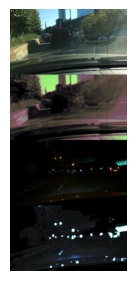

In [21]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)
torch.cuda.empty_cache()

In [23]:
torch.cuda.empty_cache()

## Step 9. Training

100%|██████████| 70/70 [01:20<00:00,  1.15s/it]


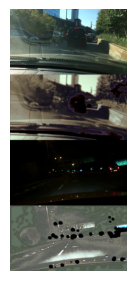

[Epoch 1/100]
[G loss: 5.9416117668151855 | identity: 0.27509060502052307 GAN: 0.9656171202659607 cycle: 0.3600541651248932]
[D loss: 0.05786459892988205 | D_A: 0.056618038564920425 D_B: 0.059111159294843674]


100%|██████████| 70/70 [01:23<00:00,  1.19s/it]


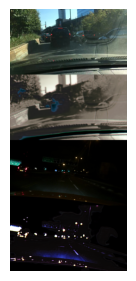

[Epoch 2/100]
[G loss: 3.3679263591766357 | identity: 0.20401087403297424 GAN: 0.8506991863250732 cycle: 0.1497172862291336]
[D loss: 0.01269618608057499 | D_A: 0.013428031466901302 D_B: 0.011964339762926102]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


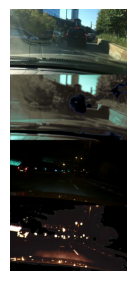

[Epoch 3/100]
[G loss: 3.2662134170532227 | identity: 0.2733820378780365 GAN: 0.9687255620956421 cycle: 0.093057781457901]
[D loss: 0.024050861597061157 | D_A: 0.012154411524534225 D_B: 0.03594731166958809]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


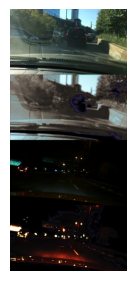

[Epoch 4/100]
[G loss: 3.0642082691192627 | identity: 0.2280006855726242 GAN: 0.7195366024971008 cycle: 0.12046682834625244]
[D loss: 0.14040672779083252 | D_A: 0.21218176186084747 D_B: 0.06863167881965637]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


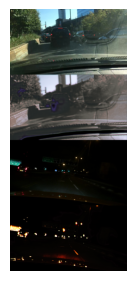

[Epoch 5/100]
[G loss: 2.7035024166107178 | identity: 0.08602844178676605 GAN: 0.996063768863678 cycle: 0.1277296394109726]
[D loss: 0.0582306906580925 | D_A: 0.1091499775648117 D_B: 0.0073114060796797276]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


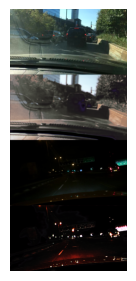

[Epoch 6/100]
[G loss: 3.0898516178131104 | identity: 0.1480693221092224 GAN: 1.0582484006881714 cycle: 0.1291256695985794]
[D loss: 0.02191387116909027 | D_A: 0.02407708391547203 D_B: 0.01975065842270851]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


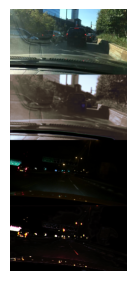

[Epoch 7/100]
[G loss: 2.846757411956787 | identity: 0.11317987740039825 GAN: 1.098883032798767 cycle: 0.11819751560688019]
[D loss: 0.06988745927810669 | D_A: 0.11201347410678864 D_B: 0.027761444449424744]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


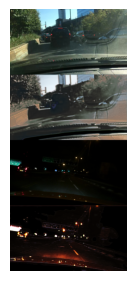

[Epoch 8/100]
[G loss: 2.558079957962036 | identity: 0.13961701095104218 GAN: 0.9271808862686157 cycle: 0.09328140318393707]
[D loss: 0.016557617112994194 | D_A: 0.02473089098930359 D_B: 0.0083843432366848]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


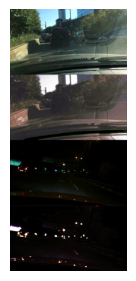

[Epoch 9/100]
[G loss: 2.6514055728912354 | identity: 0.13038817048072815 GAN: 0.6441829800605774 cycle: 0.13552817702293396]
[D loss: 0.041518114507198334 | D_A: 0.03262555971741676 D_B: 0.050410665571689606]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


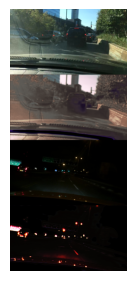

[Epoch 10/100]
[G loss: 2.870591640472412 | identity: 0.11145558953285217 GAN: 0.8400744199752808 cycle: 0.14732393622398376]
[D loss: 0.02116031013429165 | D_A: 0.028637684881687164 D_B: 0.013682935386896133]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


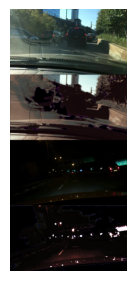

[Epoch 11/100]
[G loss: 4.945168495178223 | identity: 0.32298293709754944 GAN: 0.760678768157959 cycle: 0.2569575309753418]
[D loss: 0.2623468041419983 | D_A: 0.17013505101203918 D_B: 0.3545585870742798]


100%|██████████| 70/70 [01:23<00:00,  1.19s/it]


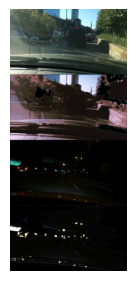

[Epoch 12/100]
[G loss: 2.923020601272583 | identity: 0.16931873559951782 GAN: 0.9396576881408691 cycle: 0.11367693543434143]
[D loss: 0.06780124455690384 | D_A: 0.04379275068640709 D_B: 0.09180973470211029]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


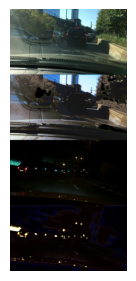

[Epoch 13/100]
[G loss: 2.55267596244812 | identity: 0.11671671271324158 GAN: 1.0417914390563965 cycle: 0.0927300900220871]
[D loss: 0.022669218480587006 | D_A: 0.019988490268588066 D_B: 0.025349948555231094]


100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


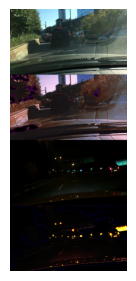

[Epoch 14/100]
[G loss: 2.5656561851501465 | identity: 0.12790706753730774 GAN: 0.9453811645507812 cycle: 0.09807396680116653]
[D loss: 0.03747192770242691 | D_A: 0.03665037453174591 D_B: 0.03829348087310791]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


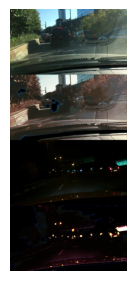

[Epoch 15/100]
[G loss: 2.777283191680908 | identity: 0.10852158069610596 GAN: 1.1409962177276611 cycle: 0.10936789214611053]
[D loss: 0.042923882603645325 | D_A: 0.023330260068178177 D_B: 0.06251750886440277]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


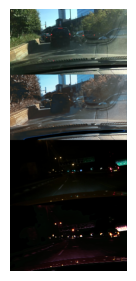

[Epoch 16/100]
[G loss: 3.156552314758301 | identity: 0.13683810830116272 GAN: 0.9971475005149841 cycle: 0.14752143621444702]
[D loss: 0.040056012570858 | D_A: 0.0545688271522522 D_B: 0.025543201714754105]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


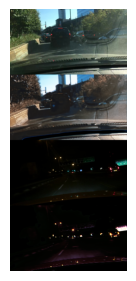

[Epoch 17/100]
[G loss: 2.3905656337738037 | identity: 0.11620545387268066 GAN: 0.6773896217346191 cycle: 0.113214872777462]
[D loss: 0.03070160001516342 | D_A: 0.020379401743412018 D_B: 0.041023798286914825]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


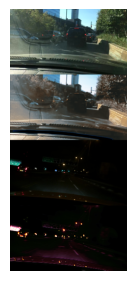

[Epoch 18/100]
[G loss: 2.3712189197540283 | identity: 0.0896933525800705 GAN: 1.1348072290420532 cycle: 0.07879448682069778]
[D loss: 0.01990475505590439 | D_A: 0.024122897535562515 D_B: 0.015686610713601112]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


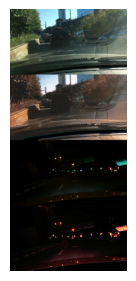

[Epoch 19/100]
[G loss: 2.3533027172088623 | identity: 0.09428089112043381 GAN: 0.997038722038269 cycle: 0.0884859636425972]
[D loss: 0.015481497161090374 | D_A: 0.016837377101182938 D_B: 0.01412561722099781]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


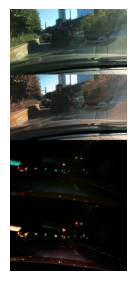

[Epoch 20/100]
[G loss: 2.3058433532714844 | identity: 0.08731149137020111 GAN: 1.0718656778335571 cycle: 0.07974202930927277]
[D loss: 0.007912332192063332 | D_A: 0.006891398690640926 D_B: 0.008933265693485737]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


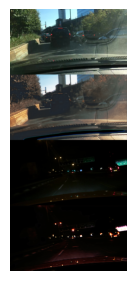

[Epoch 21/100]
[G loss: 2.426945209503174 | identity: 0.107120081782341 GAN: 0.824499249458313 cycle: 0.10668455809354782]
[D loss: 0.029850304126739502 | D_A: 0.030267076566815376 D_B: 0.029433533549308777]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


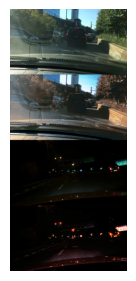

[Epoch 22/100]
[G loss: 2.4918642044067383 | identity: 0.09378215670585632 GAN: 1.014565348625183 cycle: 0.10083881765604019]
[D loss: 0.010284524410963058 | D_A: 0.015568994916975498 D_B: 0.0050000534392893314]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


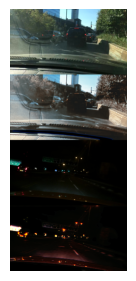

[Epoch 23/100]
[G loss: 3.3016481399536133 | identity: 0.1348603516817093 GAN: 1.0539026260375977 cycle: 0.15734437108039856]
[D loss: 0.019369207322597504 | D_A: 0.02319963462650776 D_B: 0.015538778156042099]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


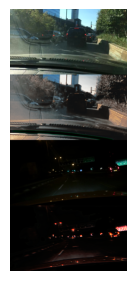

[Epoch 24/100]
[G loss: 3.035153388977051 | identity: 0.1224542111158371 GAN: 1.2964890003204346 cycle: 0.11263932287693024]
[D loss: 0.13442283868789673 | D_A: 0.004223899450153112 D_B: 0.264621764421463]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


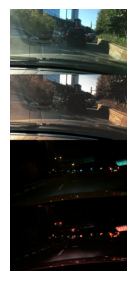

[Epoch 25/100]
[G loss: 2.240381956100464 | identity: 0.07308149337768555 GAN: 0.9898320436477661 cycle: 0.08851423859596252]
[D loss: 0.00624234089627862 | D_A: 0.004168585874140263 D_B: 0.008316095918416977]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


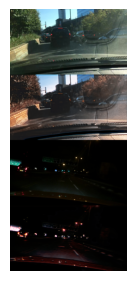

[Epoch 26/100]
[G loss: 3.7179956436157227 | identity: 0.23559391498565674 GAN: 0.7005995512008667 cycle: 0.18394264578819275]
[D loss: 0.03134802728891373 | D_A: 0.04159646853804588 D_B: 0.021099582314491272]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


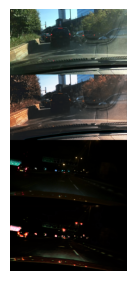

[Epoch 27/100]
[G loss: 2.0652201175689697 | identity: 0.0877886712551117 GAN: 0.8141701221466064 cycle: 0.081210657954216]
[D loss: 0.010117569006979465 | D_A: 0.005772168282419443 D_B: 0.0144629692658782]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


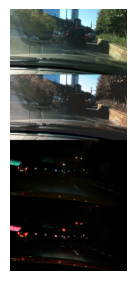

[Epoch 28/100]
[G loss: 2.691920042037964 | identity: 0.11797668039798737 GAN: 0.8608624339103699 cycle: 0.1241174191236496]
[D loss: 0.08656762540340424 | D_A: 0.020624391734600067 D_B: 0.152510866522789]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


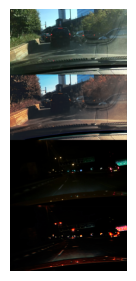

[Epoch 29/100]
[G loss: 2.68544864654541 | identity: 0.15041616559028625 GAN: 0.47137320041656494 cycle: 0.14619946479797363]
[D loss: 0.23931856453418732 | D_A: 0.4578811228275299 D_B: 0.020755993202328682]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


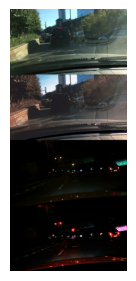

[Epoch 30/100]
[G loss: 2.064565658569336 | identity: 0.06659700721502304 GAN: 1.181383728981018 cycle: 0.05501968041062355]
[D loss: 0.06362833082675934 | D_A: 0.09893051534891129 D_B: 0.02832614816725254]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


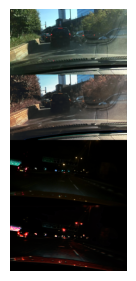

[Epoch 31/100]
[G loss: 2.7015600204467773 | identity: 0.11442352831363678 GAN: 1.0248781442642212 cycle: 0.1104564219713211]
[D loss: 0.0061827911995351315 | D_A: 0.006212195381522179 D_B: 0.006153387017548084]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


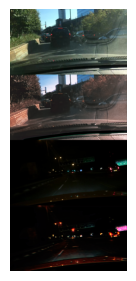

[Epoch 32/100]
[G loss: 2.1998987197875977 | identity: 0.07990755140781403 GAN: 1.0825084447860718 cycle: 0.07178527116775513]
[D loss: 0.006167242303490639 | D_A: 0.006221429444849491 D_B: 0.006113055627793074]


100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


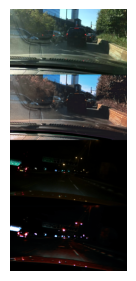

[Epoch 33/100]
[G loss: 2.0852978229522705 | identity: 0.09264574944972992 GAN: 0.936093807220459 cycle: 0.06859752535820007]
[D loss: 0.010355813428759575 | D_A: 0.007348325103521347 D_B: 0.013363302685320377]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


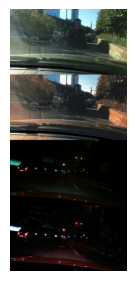

[Epoch 34/100]
[G loss: 2.7488749027252197 | identity: 0.08902468532323837 GAN: 1.0120153427124023 cycle: 0.12917360663414001]
[D loss: 0.00400633504614234 | D_A: 0.00453738309442997 D_B: 0.0034752869978547096]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


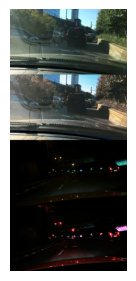

[Epoch 35/100]
[G loss: 2.0819687843322754 | identity: 0.06300441920757294 GAN: 0.9589225053787231 cycle: 0.08080241084098816]
[D loss: 0.003299269126728177 | D_A: 0.003802779596298933 D_B: 0.002795758657157421]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


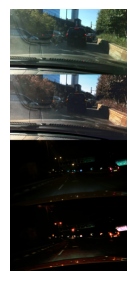

[Epoch 36/100]
[G loss: 2.231062889099121 | identity: 0.07482944428920746 GAN: 1.0761094093322754 cycle: 0.07808063924312592]
[D loss: 0.0032851388677954674 | D_A: 0.002659420482814312 D_B: 0.003910857252776623]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


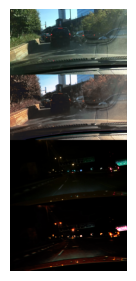

[Epoch 37/100]
[G loss: 2.181821346282959 | identity: 0.09243834763765335 GAN: 0.9032606482505798 cycle: 0.08163689076900482]
[D loss: 0.00965326651930809 | D_A: 0.007113369181752205 D_B: 0.012193163856863976]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


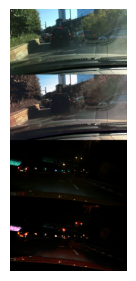

[Epoch 38/100]
[G loss: 2.0805320739746094 | identity: 0.0777672529220581 GAN: 1.0120339393615723 cycle: 0.06796617805957794]
[D loss: 0.006019290070980787 | D_A: 0.008123775944113731 D_B: 0.003914804197847843]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


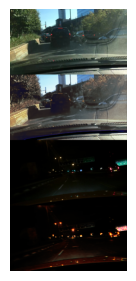

[Epoch 39/100]
[G loss: 2.3192014694213867 | identity: 0.08731018006801605 GAN: 1.0367684364318848 cycle: 0.08458821475505829]
[D loss: 0.004622042179107666 | D_A: 0.007270758971571922 D_B: 0.0019733256194740534]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


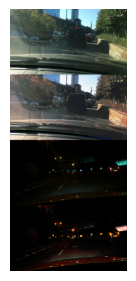

[Epoch 40/100]
[G loss: 1.956225037574768 | identity: 0.07261798530817032 GAN: 0.9588674306869507 cycle: 0.06342677026987076]
[D loss: 0.006790663581341505 | D_A: 0.006234201602637768 D_B: 0.007347125560045242]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


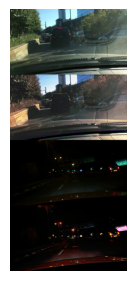

[Epoch 41/100]
[G loss: 2.5693507194519043 | identity: 0.09493294358253479 GAN: 1.0181461572647095 cycle: 0.10765400528907776]
[D loss: 0.00230839429423213 | D_A: 0.002453282941132784 D_B: 0.00216350588016212]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


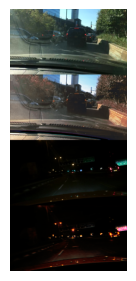

[Epoch 42/100]
[G loss: 1.7276341915130615 | identity: 0.05187513679265976 GAN: 1.0468497276306152 cycle: 0.04214088246226311]
[D loss: 0.00801206473261118 | D_A: 0.008139263838529587 D_B: 0.007884865626692772]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


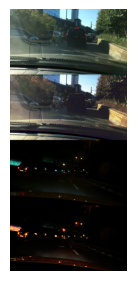

[Epoch 43/100]
[G loss: 2.357848644256592 | identity: 0.08646523952484131 GAN: 1.114560842514038 cycle: 0.08109615743160248]
[D loss: 0.005996239371597767 | D_A: 0.00888921320438385 D_B: 0.0031032655388116837]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


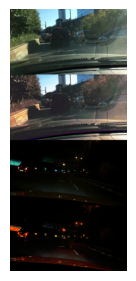

[Epoch 44/100]
[G loss: 2.074597120285034 | identity: 0.07760504633188248 GAN: 0.9395455121994019 cycle: 0.07470265030860901]
[D loss: 0.006289872340857983 | D_A: 0.009445840492844582 D_B: 0.0031339044217020273]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


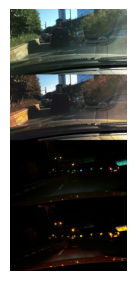

[Epoch 45/100]
[G loss: 2.0064356327056885 | identity: 0.0631496012210846 GAN: 0.8956679105758667 cycle: 0.07950197160243988]
[D loss: 0.012338528409600258 | D_A: 0.01550066564232111 D_B: 0.009176391176879406]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


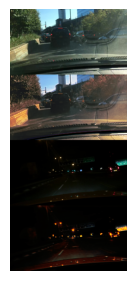

[Epoch 46/100]
[G loss: 2.328493356704712 | identity: 0.1113797277212143 GAN: 1.0954097509384155 cycle: 0.0676184892654419]
[D loss: 0.005910663865506649 | D_A: 0.008302057161927223 D_B: 0.0035192701034247875]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


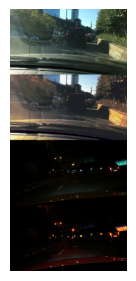

[Epoch 47/100]
[G loss: 2.5405337810516357 | identity: 0.10816602408885956 GAN: 0.9583158493041992 cycle: 0.10413877665996552]
[D loss: 0.004257026128470898 | D_A: 0.0024284357205033302 D_B: 0.006085616536438465]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


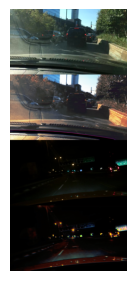

[Epoch 48/100]
[G loss: 2.186674118041992 | identity: 0.07772094756364822 GAN: 1.029708981513977 cycle: 0.07683604210615158]
[D loss: 0.009045708924531937 | D_A: 0.00781852938234806 D_B: 0.010272889398038387]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


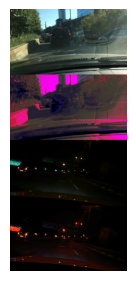

[Epoch 49/100]
[G loss: 4.107654094696045 | identity: 0.34965917468070984 GAN: 0.32500073313713074 cycle: 0.2034357488155365]
[D loss: 0.45847398042678833 | D_A: 0.3917572796344757 D_B: 0.5251907110214233]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


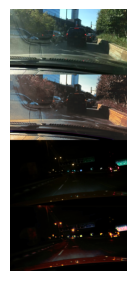

[Epoch 50/100]
[G loss: 3.246570587158203 | identity: 0.1386501044034958 GAN: 0.8459303379058838 cycle: 0.17073898017406464]
[D loss: 0.02411433309316635 | D_A: 0.02547272853553295 D_B: 0.02275593765079975]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


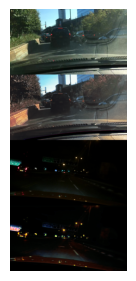

[Epoch 51/100]
[G loss: 1.9682791233062744 | identity: 0.05332426726818085 GAN: 1.0883898735046387 cycle: 0.06132679060101509]
[D loss: 0.016353575512766838 | D_A: 0.03091364912688732 D_B: 0.00179350096732378]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


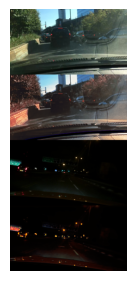

[Epoch 52/100]
[G loss: 2.2394604682922363 | identity: 0.12181828916072845 GAN: 0.8726666569709778 cycle: 0.07577022165060043]
[D loss: 0.01068334560841322 | D_A: 0.017125602811574936 D_B: 0.004241088405251503]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


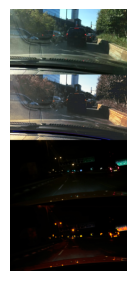

[Epoch 53/100]
[G loss: 2.012528657913208 | identity: 0.07519029825925827 GAN: 0.9392980933189392 cycle: 0.06972791254520416]
[D loss: 0.007131320424377918 | D_A: 0.010854960419237614 D_B: 0.0034076799638569355]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


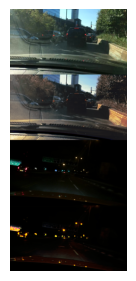

[Epoch 54/100]
[G loss: 2.2738800048828125 | identity: 0.13230393826961517 GAN: 0.5658965110778809 cycle: 0.10464636981487274]
[D loss: 0.11418230831623077 | D_A: 0.22554300725460052 D_B: 0.0028216138016432524]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


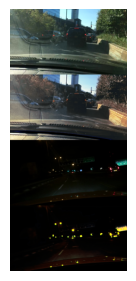

[Epoch 55/100]
[G loss: 2.099729061126709 | identity: 0.09537902474403381 GAN: 0.880306601524353 cycle: 0.07425274699926376]
[D loss: 0.008164718747138977 | D_A: 0.013985010795295238 D_B: 0.0023444262333214283]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


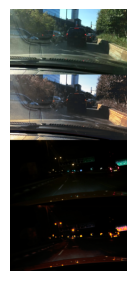

[Epoch 56/100]
[G loss: 1.9877570867538452 | identity: 0.06083817780017853 GAN: 0.9957257509231567 cycle: 0.06878404319286346]
[D loss: 0.0018171393312513828 | D_A: 0.001875629648566246 D_B: 0.0017586490139365196]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


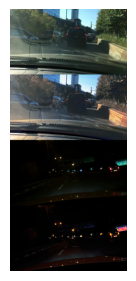

[Epoch 57/100]
[G loss: 1.6583696603775024 | identity: 0.047993604093790054 GAN: 0.9992587566375732 cycle: 0.041914284229278564]
[D loss: 0.003813427174463868 | D_A: 0.006006889045238495 D_B: 0.0016199653036892414]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


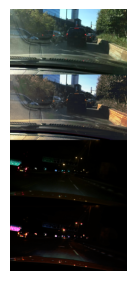

[Epoch 58/100]
[G loss: 2.012744903564453 | identity: 0.05466504395008087 GAN: 0.9567985534667969 cycle: 0.07826212048530579]
[D loss: 0.003548615612089634 | D_A: 0.0056621176190674305 D_B: 0.0014351136051118374]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


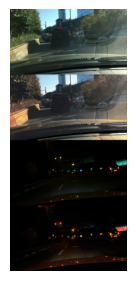

[Epoch 59/100]
[G loss: 1.8722045421600342 | identity: 0.054383233189582825 GAN: 1.0416696071624756 cycle: 0.05586187541484833]
[D loss: 0.0035180356353521347 | D_A: 0.0032794836442917585 D_B: 0.0037565873935818672]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


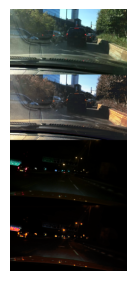

[Epoch 60/100]
[G loss: 1.6501145362854004 | identity: 0.05102112516760826 GAN: 1.0131067037582397 cycle: 0.038190219551324844]
[D loss: 0.009716085158288479 | D_A: 0.017159800976514816 D_B: 0.0022723691072314978]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


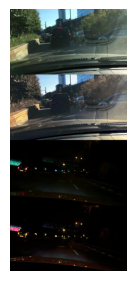

[Epoch 61/100]
[G loss: 2.4145519733428955 | identity: 0.09220734983682632 GAN: 1.000091314315796 cycle: 0.09534239768981934]
[D loss: 0.0023922519758343697 | D_A: 0.0031339521519839764 D_B: 0.0016505520325154066]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


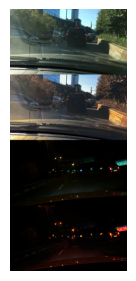

[Epoch 62/100]
[G loss: 1.8035098314285278 | identity: 0.0560854896903038 GAN: 1.0065865516662598 cycle: 0.051649585366249084]
[D loss: 0.004962891805917025 | D_A: 0.005800000391900539 D_B: 0.00412578321993351]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


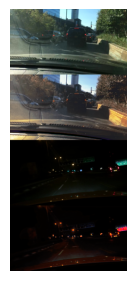

[Epoch 63/100]
[G loss: 2.150144577026367 | identity: 0.07664994895458221 GAN: 1.0041511058807373 cycle: 0.07627436518669128]
[D loss: 0.001677351538091898 | D_A: 0.0022377034183591604 D_B: 0.0011169996578246355]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


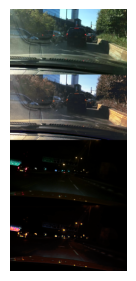

[Epoch 64/100]
[G loss: 2.6124377250671387 | identity: 0.12175089120864868 GAN: 0.910781979560852 cycle: 0.10929010808467865]
[D loss: 0.0064937821589410305 | D_A: 0.008997663855552673 D_B: 0.003989900462329388]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


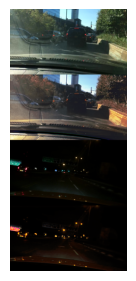

[Epoch 65/100]
[G loss: 2.0912234783172607 | identity: 0.07645143568515778 GAN: 0.9890284538269043 cycle: 0.07199378311634064]
[D loss: 0.002717440016567707 | D_A: 0.001335255103185773 D_B: 0.004099624697118998]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


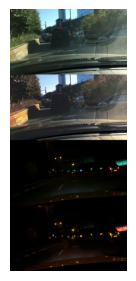

[Epoch 66/100]
[G loss: 1.6419484615325928 | identity: 0.04945378750562668 GAN: 0.9617136120796204 cycle: 0.04329659044742584]
[D loss: 0.0026623993180692196 | D_A: 0.0044482010416686535 D_B: 0.0008765977690927684]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


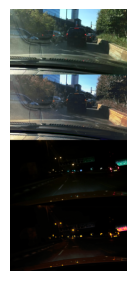

[Epoch 67/100]
[G loss: 1.7639987468719482 | identity: 0.06790380924940109 GAN: 0.9487273097038269 cycle: 0.04757523909211159]
[D loss: 0.003561119781807065 | D_A: 0.0022865976206958294 D_B: 0.004835641942918301]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


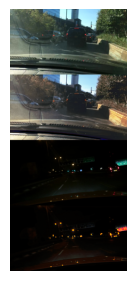

[Epoch 68/100]
[G loss: 1.9153424501419067 | identity: 0.06854894757270813 GAN: 0.9210748672485352 cycle: 0.06515228748321533]
[D loss: 0.0058339303359389305 | D_A: 0.009783770889043808 D_B: 0.0018840893171727657]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


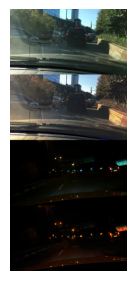

[Epoch 69/100]
[G loss: 1.6161178350448608 | identity: 0.06876378506422043 GAN: 0.8186982870101929 cycle: 0.04536006227135658]
[D loss: 0.008507869206368923 | D_A: 0.009298115968704224 D_B: 0.0077176219783723354]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


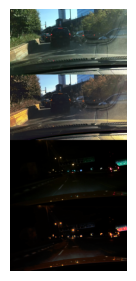

[Epoch 70/100]
[G loss: 1.544819712638855 | identity: 0.08365045487880707 GAN: 0.6357675790786743 cycle: 0.049079980701208115]
[D loss: 0.11825662106275558 | D_A: 0.07413053512573242 D_B: 0.16238270699977875]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


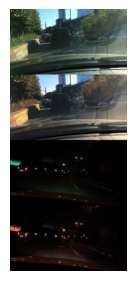

[Epoch 71/100]
[G loss: 1.8124594688415527 | identity: 0.05674729496240616 GAN: 0.9819517135620117 cycle: 0.05467713624238968]
[D loss: 0.005669858306646347 | D_A: 0.010203491896390915 D_B: 0.0011362251825630665]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


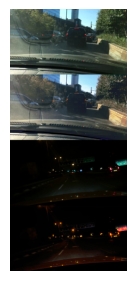

[Epoch 72/100]
[G loss: 2.0719661712646484 | identity: 0.0890689566731453 GAN: 0.9745259284973145 cycle: 0.0652095377445221]
[D loss: 0.004419100005179644 | D_A: 0.007437211461365223 D_B: 0.0014009884325787425]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


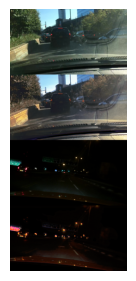

[Epoch 73/100]
[G loss: 2.244196891784668 | identity: 0.0650767982006073 GAN: 1.1641058921813965 cycle: 0.0754707008600235]
[D loss: 0.021537398919463158 | D_A: 0.041612930595874786 D_B: 0.0014618667773902416]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


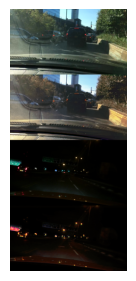

[Epoch 74/100]
[G loss: 2.00304913520813 | identity: 0.06132878363132477 GAN: 1.0459158420562744 cycle: 0.0650489330291748]
[D loss: 0.005617358721792698 | D_A: 0.007654605899006128 D_B: 0.00358011107891798]


100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


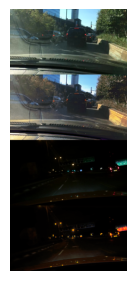

[Epoch 75/100]
[G loss: 1.5191411972045898 | identity: 0.06302488595247269 GAN: 0.7496567964553833 cycle: 0.04543600603938103]
[D loss: 0.15413571894168854 | D_A: 0.2695316672325134 D_B: 0.03873977065086365]


100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


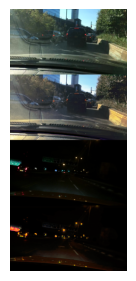

[Epoch 76/100]
[G loss: 2.588587999343872 | identity: 0.11298811435699463 GAN: 1.0177563428878784 cycle: 0.10058911144733429]
[D loss: 0.0025563924573361874 | D_A: 0.0025303501170128584 D_B: 0.0025824347976595163]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


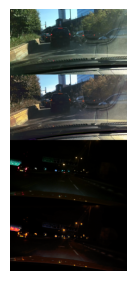

[Epoch 77/100]
[G loss: 2.0442776679992676 | identity: 0.06350082159042358 GAN: 1.0277588367462158 cycle: 0.0699014663696289]
[D loss: 0.005602801684290171 | D_A: 0.008303675800561905 D_B: 0.0029019275680184364]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


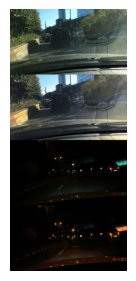

[Epoch 78/100]
[G loss: 1.896276831626892 | identity: 0.05532213672995567 GAN: 1.0682814121246338 cycle: 0.0551384836435318]
[D loss: 0.0031628692522644997 | D_A: 0.004290812183171511 D_B: 0.0020349265541881323]


100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


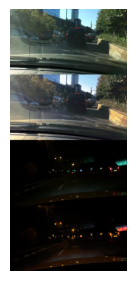

[Epoch 79/100]
[G loss: 1.7336928844451904 | identity: 0.05102699622511864 GAN: 1.0182368755340576 cycle: 0.046032100915908813]
[D loss: 0.004361015744507313 | D_A: 0.007340555544942617 D_B: 0.0013814755948260427]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


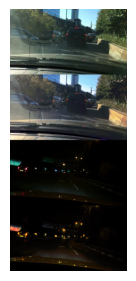

[Epoch 80/100]
[G loss: 1.4861230850219727 | identity: 0.03917554393410683 GAN: 0.9703744649887085 cycle: 0.03198709338903427]
[D loss: 0.011223167181015015 | D_A: 0.018459171056747437 D_B: 0.003987162373960018]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


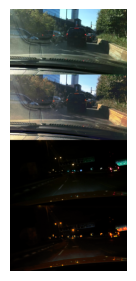

[Epoch 81/100]
[G loss: 2.0450167655944824 | identity: 0.0699884220957756 GAN: 0.9950617551803589 cycle: 0.0700012817978859]
[D loss: 0.0018153804121538997 | D_A: 0.002288948278874159 D_B: 0.0013418125454336405]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


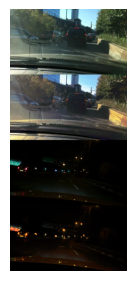

[Epoch 82/100]
[G loss: 1.8091415166854858 | identity: 0.04942917078733444 GAN: 1.0468261241912842 cycle: 0.051516950130462646]
[D loss: 0.012709278613328934 | D_A: 0.01874072290956974 D_B: 0.006677835248410702]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


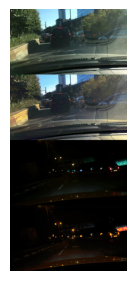

[Epoch 83/100]
[G loss: 1.6718113422393799 | identity: 0.05034609138965607 GAN: 0.9699183702468872 cycle: 0.04501625895500183]
[D loss: 0.0022601322270929813 | D_A: 0.0028210552409291267 D_B: 0.0016992093296721578]


100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


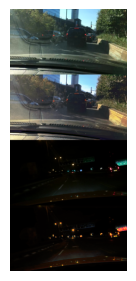

[Epoch 84/100]
[G loss: 1.5200002193450928 | identity: 0.03532151132822037 GAN: 1.0314027070999146 cycle: 0.031198997050523758]
[D loss: 0.03489323705434799 | D_A: 0.057899169623851776 D_B: 0.011887302622199059]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


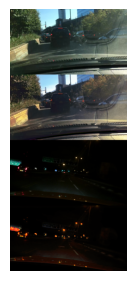

[Epoch 85/100]
[G loss: 1.8482418060302734 | identity: 0.061854977160692215 GAN: 1.038130521774292 cycle: 0.05008363723754883]
[D loss: 0.0025074928998947144 | D_A: 0.004175497218966484 D_B: 0.0008394885808229446]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


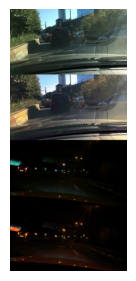

[Epoch 86/100]
[G loss: 1.9347209930419922 | identity: 0.05124455690383911 GAN: 1.139430284500122 cycle: 0.05390680208802223]
[D loss: 0.014270110987126827 | D_A: 0.026052655652165413 D_B: 0.0024875665549188852]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


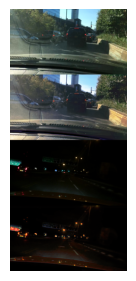

[Epoch 87/100]
[G loss: 1.738633394241333 | identity: 0.04704991355538368 GAN: 0.9975606203079224 cycle: 0.050582319498062134]
[D loss: 0.01566302590072155 | D_A: 0.02435087226331234 D_B: 0.006975180469453335]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


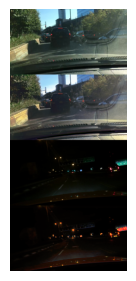

[Epoch 88/100]
[G loss: 1.463526964187622 | identity: 0.031838007271289825 GAN: 1.0028045177459717 cycle: 0.030153244733810425]
[D loss: 0.003178067971020937 | D_A: 0.005724807735532522 D_B: 0.0006313283229246736]


100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


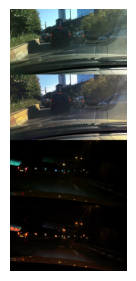

[Epoch 89/100]
[G loss: 1.5059285163879395 | identity: 0.033175211399793625 GAN: 1.0528013706207275 cycle: 0.02872510999441147]
[D loss: 0.0015701104421168566 | D_A: 0.002464190823957324 D_B: 0.0006760300020687282]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


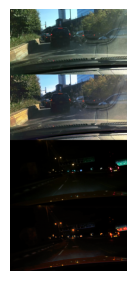

[Epoch 90/100]
[G loss: 1.742229700088501 | identity: 0.04888010025024414 GAN: 1.01788330078125 cycle: 0.04799458384513855]
[D loss: 0.0031336420215666294 | D_A: 0.004652919247746468 D_B: 0.0016143647953867912]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


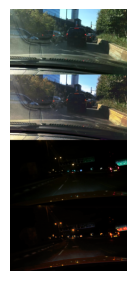

[Epoch 91/100]
[G loss: 1.5766507387161255 | identity: 0.04942512884736061 GAN: 0.9556623697280884 cycle: 0.037386272102594376]
[D loss: 0.008115322329103947 | D_A: 0.015262995846569538 D_B: 0.0009676487534306943]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


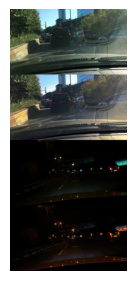

[Epoch 92/100]
[G loss: 1.5590322017669678 | identity: 0.03818421810865402 GAN: 1.0013877153396606 cycle: 0.03667233884334564]
[D loss: 0.0009607362444512546 | D_A: 0.001421346329152584 D_B: 0.0005001261597499251]


100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


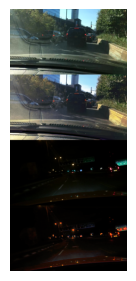

[Epoch 93/100]
[G loss: 1.7065906524658203 | identity: 0.04838978499174118 GAN: 0.9884871244430542 cycle: 0.047615449875593185]
[D loss: 0.0011957177193835378 | D_A: 0.0017969212494790554 D_B: 0.0005945141892880201]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


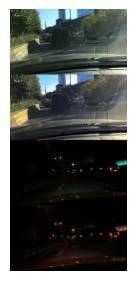

[Epoch 94/100]
[G loss: 1.5380284786224365 | identity: 0.04281125217676163 GAN: 1.0110981464385986 cycle: 0.03128740191459656]
[D loss: 0.0008102436549961567 | D_A: 0.001232073176652193 D_B: 0.00038841419154778123]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


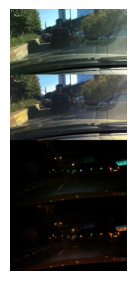

[Epoch 95/100]
[G loss: 1.5467758178710938 | identity: 0.04150291904807091 GAN: 1.002832293510437 cycle: 0.03364289551973343]
[D loss: 0.002237760229036212 | D_A: 0.003919770009815693 D_B: 0.0005557502736337483]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


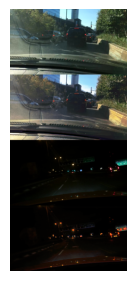

[Epoch 96/100]
[G loss: 1.7934904098510742 | identity: 0.059493862092494965 GAN: 1.0167601108551025 cycle: 0.047926098108291626]
[D loss: 0.00151581852696836 | D_A: 0.0020703738555312157 D_B: 0.0009612631984055042]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


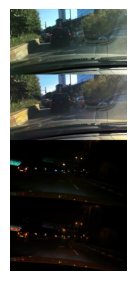

[Epoch 97/100]
[G loss: 1.430677056312561 | identity: 0.030370939522981644 GAN: 1.0332224369049072 cycle: 0.02455998584628105]
[D loss: 0.0010108859278261662 | D_A: 0.0014942701673135161 D_B: 0.000527501804754138]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


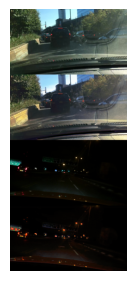

[Epoch 98/100]
[G loss: 1.7324693202972412 | identity: 0.05790518969297409 GAN: 1.0078024864196777 cycle: 0.04351408779621124]
[D loss: 0.0012501644669100642 | D_A: 0.0016605323180556297 D_B: 0.0008397966157644987]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


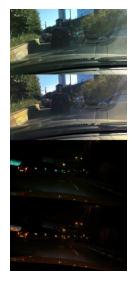

[Epoch 99/100]
[G loss: 1.4920339584350586 | identity: 0.040679726749658585 GAN: 0.9735546112060547 cycle: 0.031508076936006546]
[D loss: 0.0011624342296272516 | D_A: 0.0017646279884502292 D_B: 0.0005602403543889523]


100%|██████████| 70/70 [01:23<00:00,  1.20s/it]


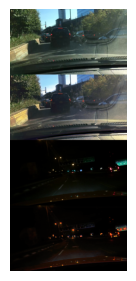

[Epoch 100/100]
[G loss: 1.6187665462493896 | identity: 0.05840523540973663 GAN: 0.9810289144515991 cycle: 0.03457114100456238]
[D loss: 0.00284652435220778 | D_A: 0.004986404441297054 D_B: 0.0007066440884955227]


In [24]:
from tqdm import tqdm
for epoch in range(n_epoches):
    
    for i, (real_A, real_B) in (enumerate(tqdm(trainloader))):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    # if (epoch+1) % 10 == 0:
    test_real_A, test_real_B = next(iter(testloader))
    sample_images(test_real_A, test_real_B)

    loss_D = (loss_D_A + loss_D_B) / 2
    print(f'[Epoch {epoch+1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    

## Step 10. Generate Images

In [33]:
photo_dir = os.path.join(data_dir, 'BDD_test')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

38

In [34]:
save_dir = '../GAN/generated_images_v1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [35]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_AB.eval()



GeneratorResNet(
  (conv): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (down): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (trans): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)


In [36]:

for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)
    
    # generate
    fake_imgs = G_AB(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")